In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
import kuka_utils as u
from datetime import datetime
import sys
from scipy.stats import linregress



In [2]:

pols = ['vv', 'hv', 'vh', 'hh']

date_list = [
             '20191107',
            '20191114',
            '20191220',
            '20191226',
            '20200102',
            '20200109',
            '20200112',
            '20200116',
            '20200119',
            '20200123',
            '20200124',
            '20200130', 
            ]

areas = u.areas()
# kvmin = 1.4
# kvmax = 2.2
band = ['Ka', 'Ku']

dpi = 600
area_list = [keys for keys in areas]


In [3]:
def plot_all_dates(binsize = 50, area = ''):
    
    #which areas to plot
    area = '' #all areas

    if area != '':
        area_list = [area]
    else: 
        area_list = [keys for keys in areas]
#     print('area_list', area_list)

    #plot settings
    lim = [1.4,2]
    markersize = .4
    alpha = .8
    sym = 'rx'
    n_plots = 8
    j, jax = plt.subplots(n_plots, 2, figsize = (3.45, 15))
    j.subplots_adjust(hspace = .25, wspace = .25)
    plt.rcParams.update({'font.size': 9})
    ticks = np.arange(4)/4
    band = ['Ka', 'Ku']
    pol = ['hh', 'vh']
    
    #make dict to contain all values
    summ = {}
    summ['vs_list'] = []
    add_list = ['', 'cs2_alt_']

    #loop through to calculate values and plot
    for add in add_list:
        summ[add] = {}
        if add == '':
            n = 0
        elif add == 'cs2_alt_':
            n = 1
        x_y_p_path = '/Volumes/bigLacie/processed_stare_' + add + 'new_nrcs/'
        file = 'snow_depths.p'
        all_dates = pickle.load( open( x_y_p_path + 'all_dates_snow_depths/' + file, "rb" ) )

        #on 2020-02-12 all the Ka runway values are missing so make an array of nans to fill that
        all_dates['Ka']['20200112']['Runway'] = {}
        all_dates['Ka']['20200112']['Runway'][binsize] = {}
        for key in all_dates['Ku']['20200112']['Runway'][binsize]:
#             print(key)
            fill_shape = all_dates['Ku']['20200112']['Runway'][binsize][key].shape
            all_dates['Ka']['20200112']['Runway'][binsize][key] = np.full(fill_shape, np.nan)

        for b in band:
            summ[add][b] = {
                        'pol_peak':[],
                        'pol_centroid':[],
                        'magna':[]
                        }

            for p in pol:
                summ[add][b][p + '_peak'] = []
                summ[add][b][p + '_centroid'] = []

            for a in area_list:
                #for each area get all binned magna snow depths from all dates

                for date in date_list:
                    #get the speed reduction for that date
                    dens, vs = u.dt_to_dens(datetime(int(date[0:4]), int(date[4:6]), int(date[6:8])))

                    #check if data on that date 
                    check_file = len(fnmatch.filter(os.listdir(x_y_p_path + 'x_y_p/'), 'x_y_p_'+date+'_'+b+'.p'))
                    if (check_file == 1 or (date == '20200112' and b == 'Ka' and a == 'Runway')):
#                         print(b, a, date)

                        #check if data in that area
                        if all_dates[b][date][a] != {}:
                            if b == band[0] and add == add_list[0]:
                                summ['vs_list'].extend([vs]*len(all_dates[b][date][a][binsize]['magna'].flatten()))
                            summ[add][b]['magna'].extend(all_dates[b][date][a][binsize]['magna'].flatten())
                            summ[add][b]['pol_peak'].extend(all_dates[b][date][a][binsize]['pol_peak'].flatten())
                            summ[add][b]['pol_centroid'].extend(all_dates[b][date][a][binsize]['pol_centroid'].flatten())

                            #get the binned ranges for peaks and centroids for both pols
                            for p in pol:
                                summ[add][b][p+'_peak'].extend(all_dates[b][date][a][binsize][p+'_peak'].flatten())
                                summ[add][b][p+'_centroid'].extend(all_dates[b][date][a][binsize][p+'_centroid'].flatten())

            for key in summ[add][b]:
                summ[add][b][key] = np.array(summ[add][b][key])
                            
        for i in range(8):
            if i == 0:
#                 x = np.array(mean_ku_magna)
                x = summ[add]['Ku']['magna']
                x_label =    'MagnaProbe Snow Depth (m)'
                y = summ[add]['Ku']['pol_peak']
                y_label =    'Ku VH Peak - \nKu HH Peak (m)'
            elif i == 1:
                x = summ[add]['Ku']['magna']
                x_label =    'MagnaProbe Snow Depth (m)'
                y = summ[add]['Ku']['pol_centroid']
                y_label =    'Ku VH Centroid - \nKu HH Centroid (m)'
            elif i == 2:
                x = summ[add]['Ka']['magna']
                x_label =    'MagnaProbe Snow Depth (m)'
                y = summ[add]['Ka']['pol_peak']
                y_label =    'Ka VH Peak - \nKa HH Peak (m)'
            elif i == 3:
                x = summ[add]['Ka']['magna']
                x_label =    'MagnaProbe Snow Depth (m)'
                y = summ[add]['Ka']['pol_centroid']
                y_label =    'Ka VH Centroid - \nKa HH Centroid (m)'
            elif i == 4:
                x = (summ[add]['Ka']['magna'] + summ[add]['Ku']['magna'])/2
                x_label =    'MagnaProbe Snow Depth (m)'
                y = (summ[add]['Ku']['hh_peak'] - summ[add]['Ka']['hh_peak'])*summ['vs_list']
                y_label =    'Ku HH Peak - \nKa HH Peak (m)'
            elif i == 5:
                x = (summ[add]['Ka']['magna'] + summ[add]['Ku']['magna'])/2
                x_label =    'MagnaProbe Snow Depth (m)'
                y = (summ[add]['Ku']['hh_centroid'] - summ[add]['Ka']['hh_centroid'])*summ['vs_list']
                y_label =    'Ku HH Centroid - \nKa HH Centroid (m)'
            elif i == 6:
                x = summ[add]['Ku']['magna']
                x_label =    'MagnaProbe Snow Depth (m)'
                y = (summ[add]['Ku']['hh_centroid'] - summ[add]['Ku']['hh_peak'])*summ['vs_list']
                y_label =    'Ku HH Centroid - \nKu HH Peak (m)'
            elif i == 7:
                x = summ[add]['Ka']['magna']
                x_label =    'MagnaProbe Snow Depth (m)'
                y = (summ[add]['Ka']['hh_centroid'] - summ[add]['Ka']['hh_peak'])*summ['vs_list']
                y_label =    'Ka HH Centroid - \nKa HH Peak (m)'

            jax[i, n].plot(x, y, 'k.', markersize = markersize, alpha = alpha)
            x_mean = np.mean(x[x == x])
            y_mean = np.mean(y[y == y])
            jax[i, n].plot(x_mean, y_mean, sym)
            coord = '(' + str('{:.2f}'.format(x_mean)) + ',' + str('{:.2f}'.format(y_mean)) + ')'        

            jax[i, n].text(.2, .05, coord, c = 'r', transform=jax[i, n].transAxes)#, 'r')

            values = np.where((x == x) & (y == y))[0]
            if len(values) > 0:
                slope, intercept, r_value, p_value, std_err = linregress(x[values], y[values])
                jax[i, n].text(.07, .85, '$r^2$: ' + str(round(r_value**2, 2)), transform=jax[i, n].transAxes)
                jax[i, n].text(.07, .75, '$n$: ' + str(len(values)), transform=jax[i, n].transAxes)
                summ[add][x_label + y_label] = [slope, intercept, r_value, p_value, std_err]

            jax[i, 0].set_ylabel(y_label)
            jax[i, 1].set_yticklabels([])

            for i in range(n_plots):
                jax[i, n].plot([-2, 2], [-2, 2], 'gray', linewidth = .5, alpha = .5)
                jax[i, n].set_xlim(-.15, .75)
                jax[i, n].set_ylim(-.15, .75)
                jax[i, n].set_xticks(ticks)
                jax[i, n].set_xticklabels([])
                jax[i, n].set_yticks(ticks)
            jax[i, n].set_xlabel('MagnaProbe\n Snow Depth (m)')
            jax[i, n].set_xticklabels(ticks)

    jax[0, 0].set_title('Full Bandwidth')
    jax[0, 1].set_title('Sub-banded')
    jax[4, 0].set_title('Full Bandwidth')
    jax[4, 1].set_title('Sub-banded')

    jax[1, 0].text(-.8, 0.4, 'Ku-band Polarisation Techniques', rotation = 90, transform=jax[1,0].transAxes)
    jax[3, 0].text(-.8, 0.4, 'Ka-band Polarisation Techniques', rotation = 90, transform=jax[3,0].transAxes)
    jax[5, 0].text(-.8, 0.5, 'Frequency Techniques', rotation = 90, transform=jax[5,0].transAxes)
    jax[7, 0].text(-.8, 0.4, 'Waveform Shape Techniques', rotation = 90, transform=jax[7,0].transAxes)

    filename = 'willatt_figure_4_' + str(binsize) + area + '.jpg'
    plt.savefig('/Users/rosie/Documents/papers/mac_rosie_mosaic/' + filename ,
               bbox_inches='tight', dpi = 300)
    plt.show()

    pickle.dump(summ, 
                open('/Users/rosie/Documents/papers/mac_rosie_mosaic/summ_dates_binsize' + str(binsize) + area + '.p','wb'))



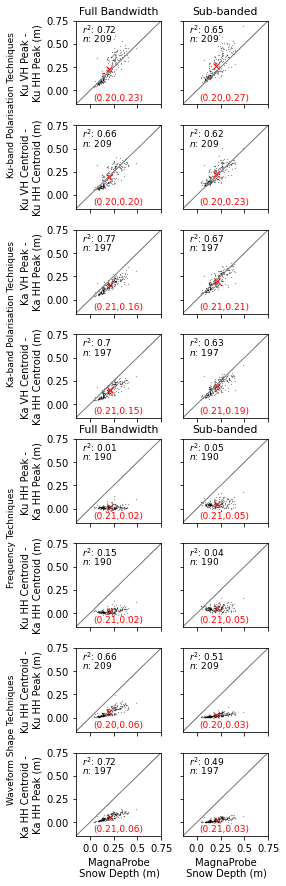

In [4]:
#make files with 50 m binsize to make figure 4
binsizes = [50]
for binsize in binsizes:
    plot_all_dates(binsize = binsize)

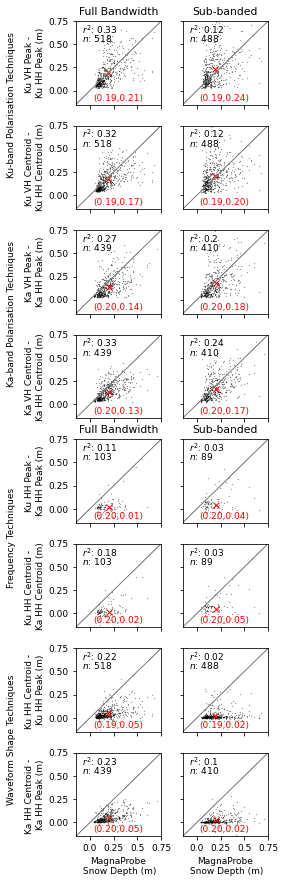

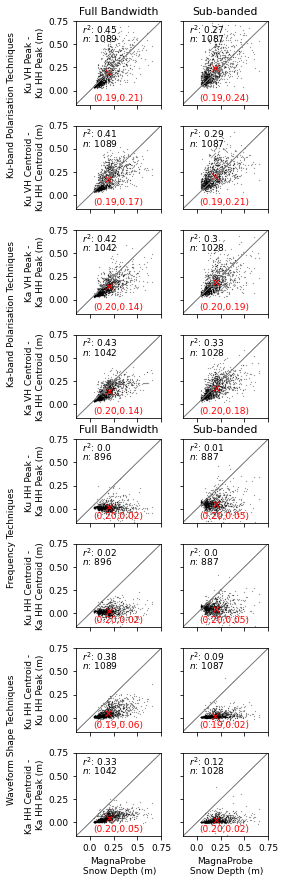

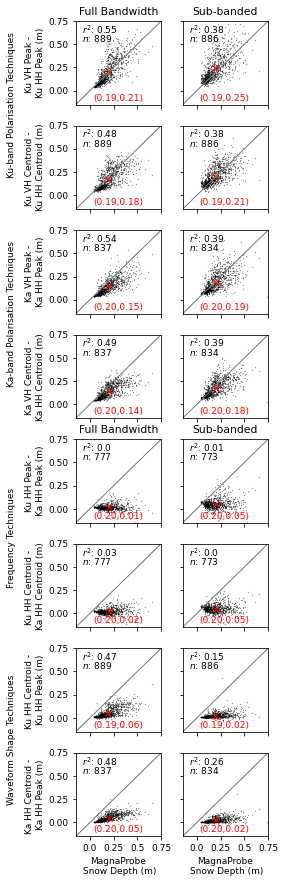

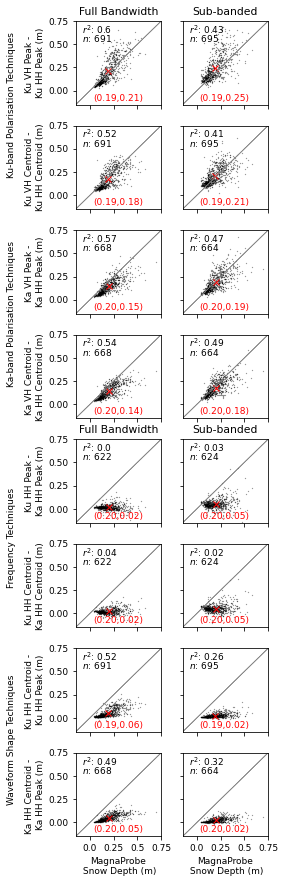

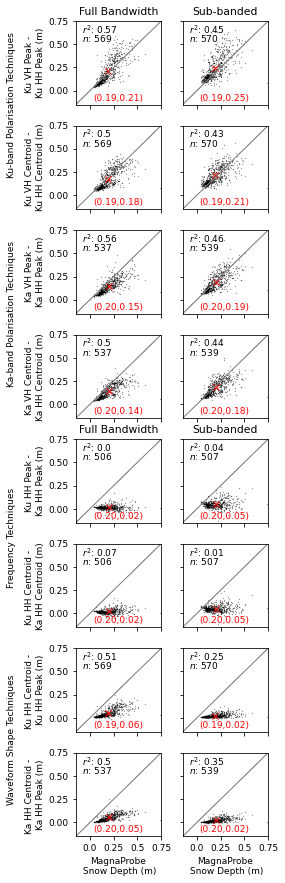

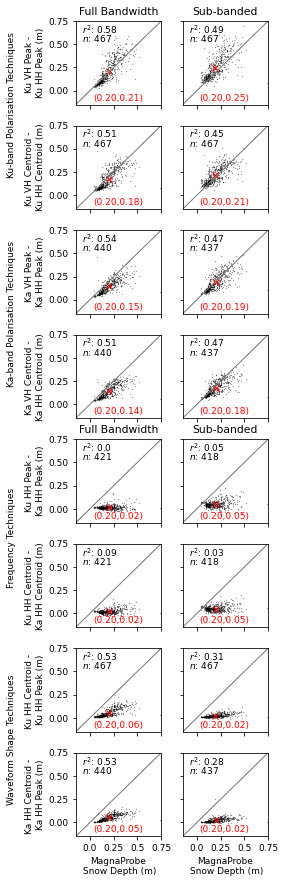

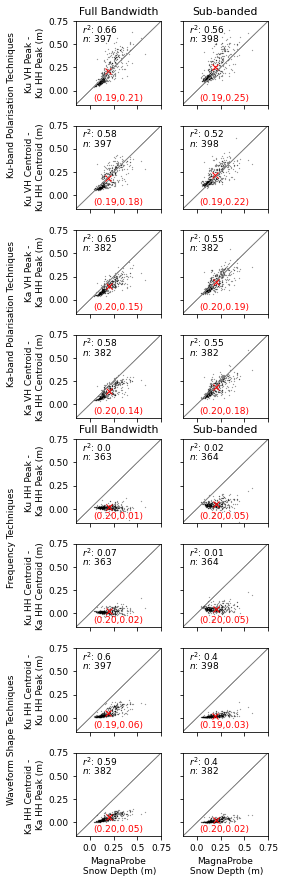

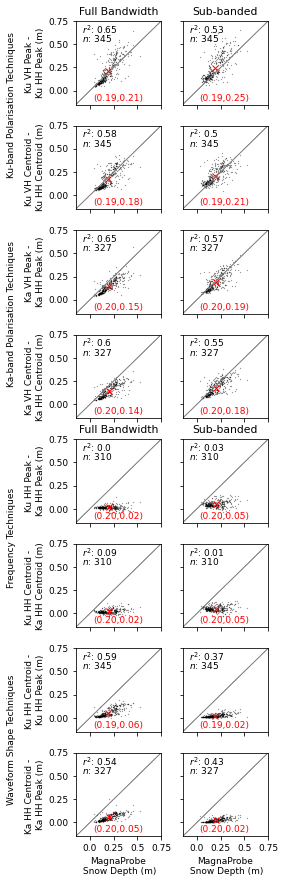

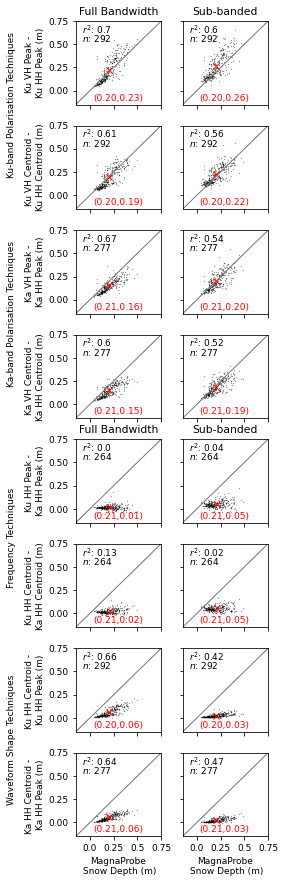

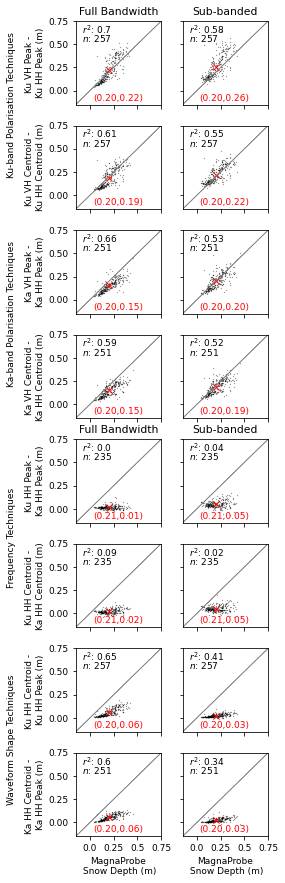

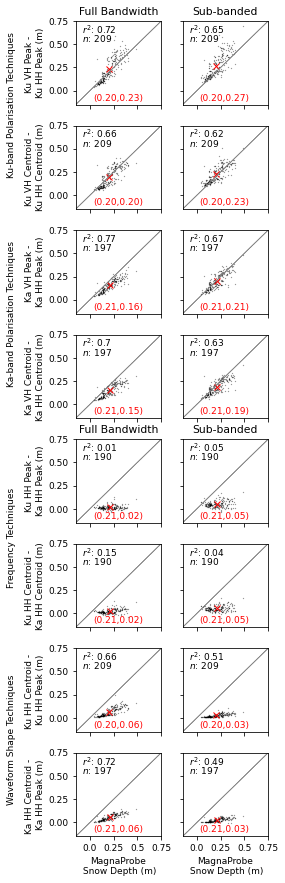

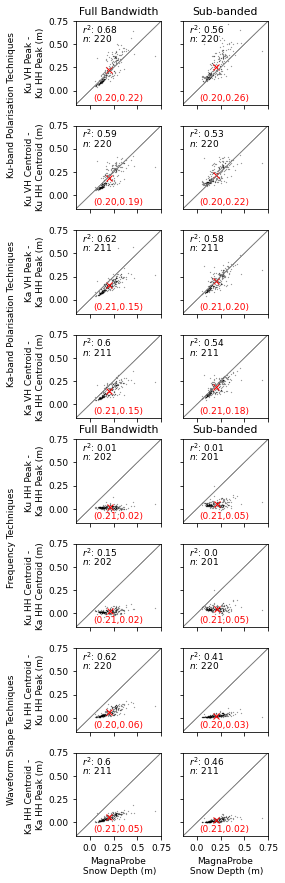

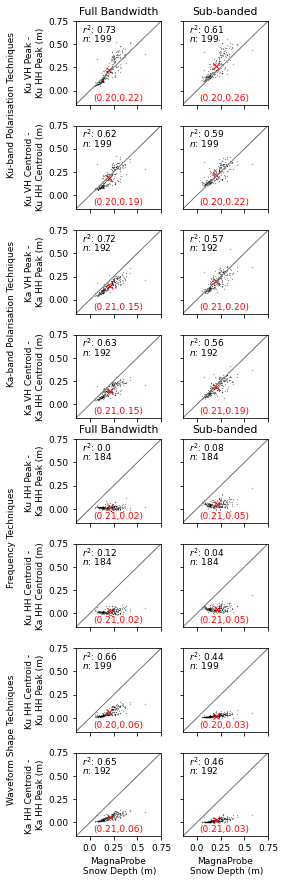

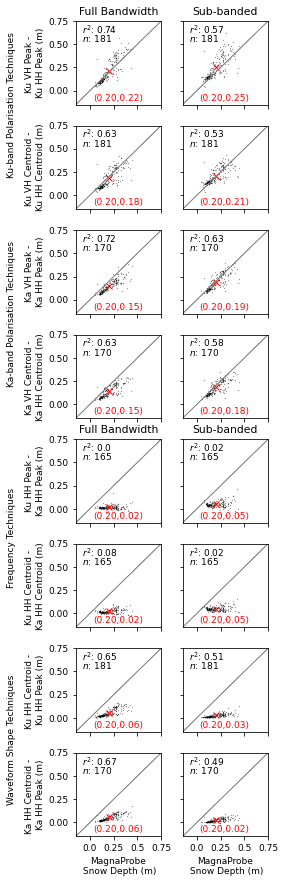

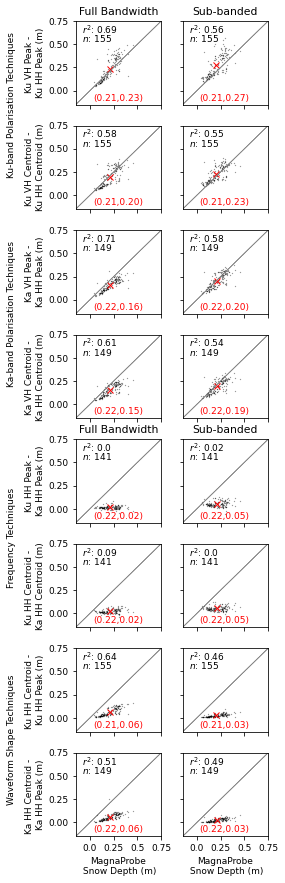

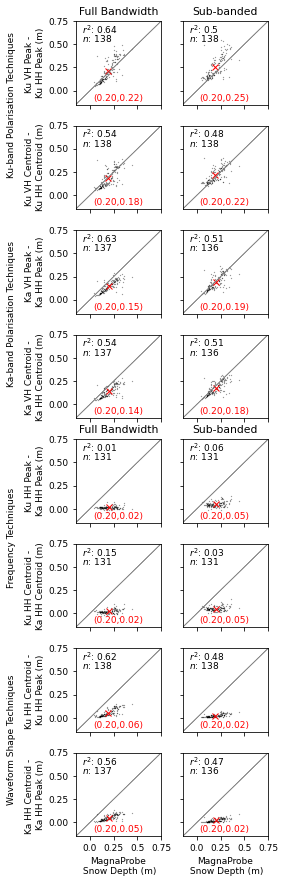

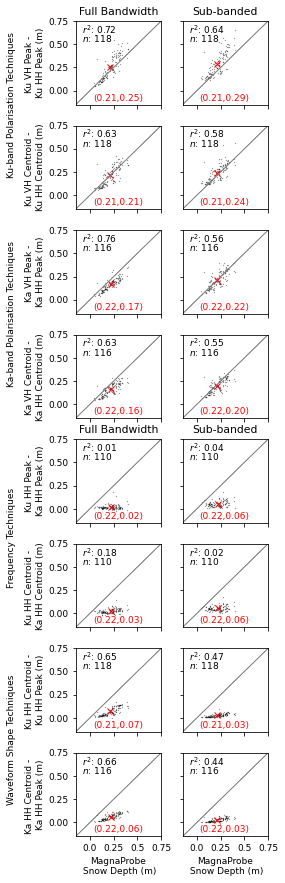

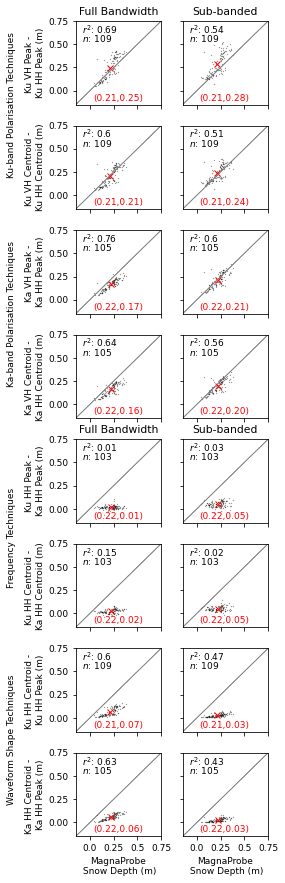

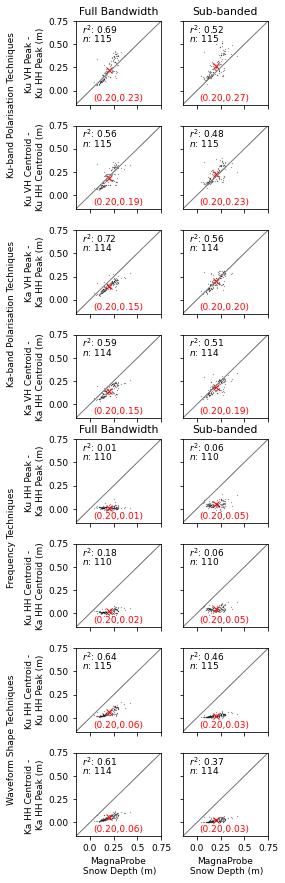

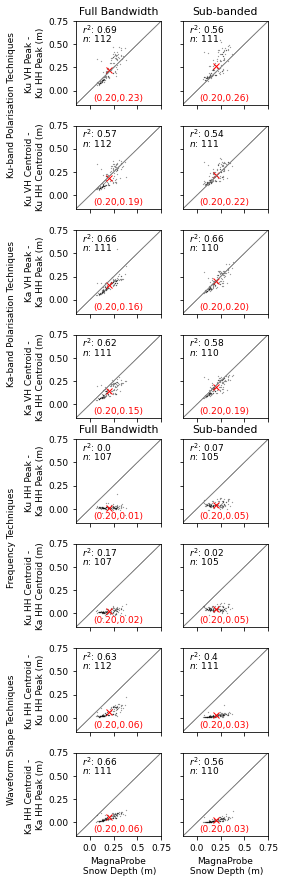

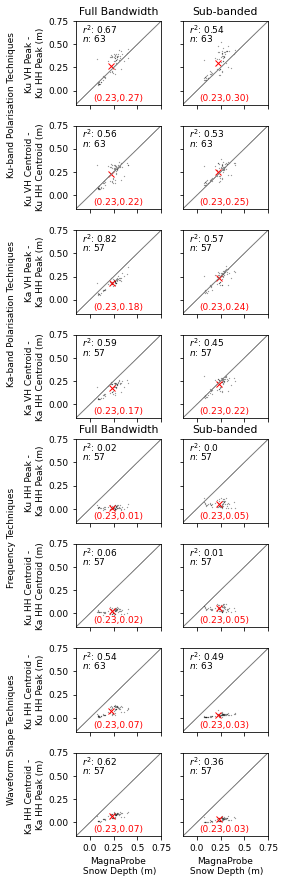

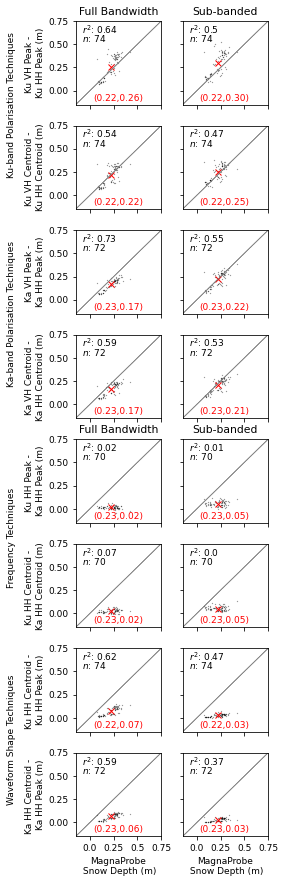

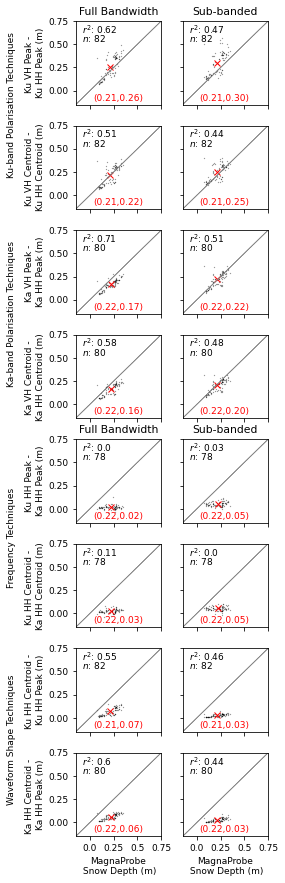

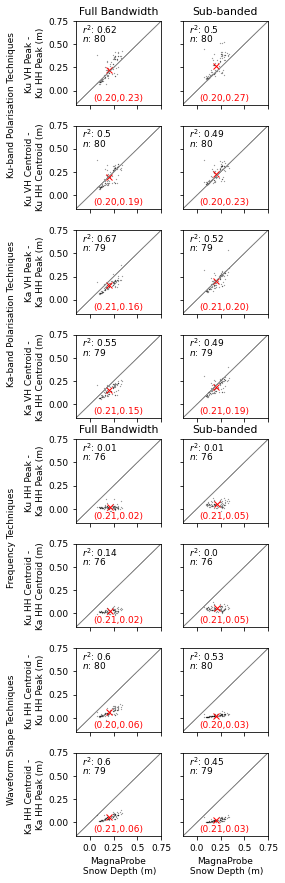

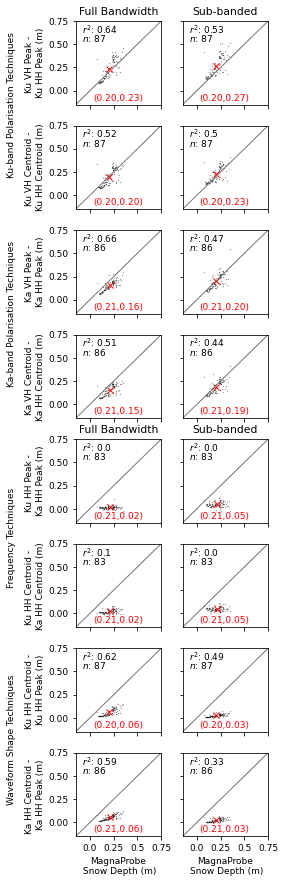

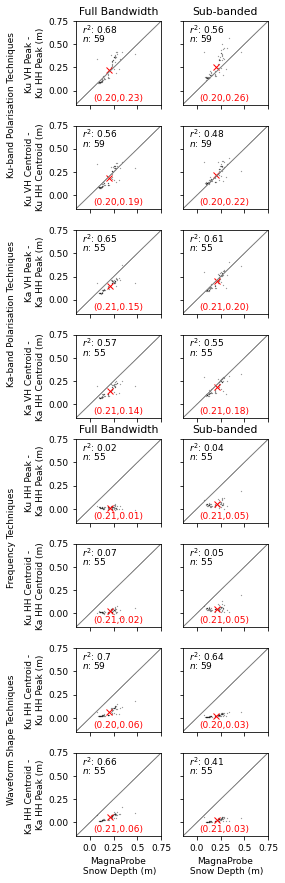

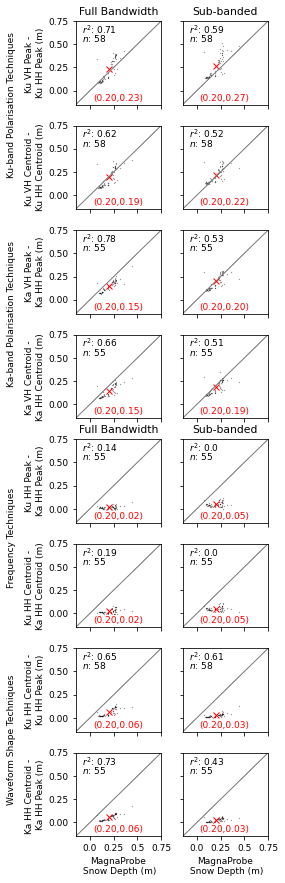

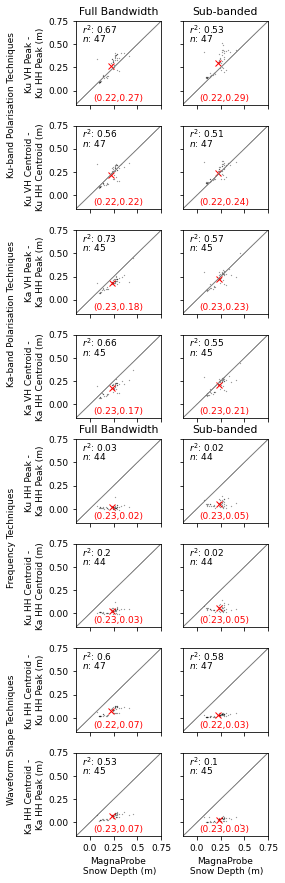

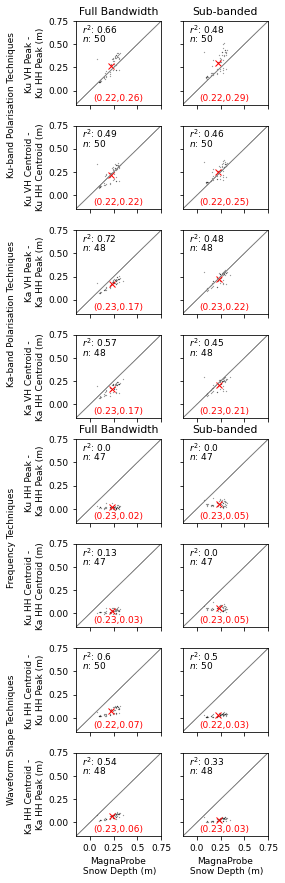

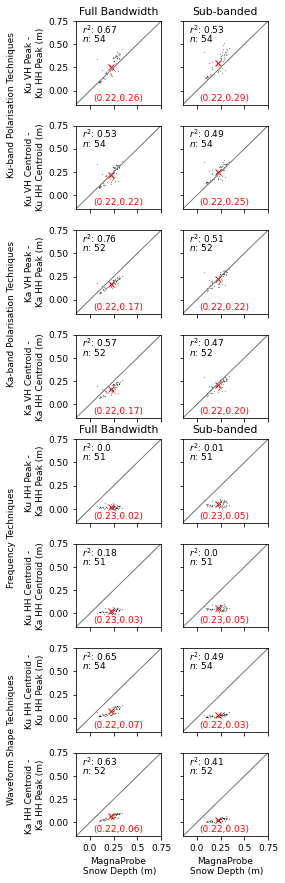

In [5]:
#make files with all binsizes to compare r values - this is needed for figure S8
binsizes = np.concatenate((np.array([1]), np.arange(5,150,5)))
for binsize in binsizes:
    plot_all_dates(binsize = binsize)